[Last time](linear-algebra-and-the-buckingham-pi-theorem.html) we showed that the Buckingham Pi theorem follows directly from one of the central results of linear algebra:
the [rank-nullity theorem](https://en.wikipedia.org/wiki/Rank%E2%80%93nullity_theorem).

The normal approach to dimensional analysis involves a certain amount of playing with the parameters, reorganizing them, and looking for their nondimensional combinations.
The understanding from a linear algebra standpoint suggests the possibility of making a computer perform dimensional analysis for you.
After all, computers are very, very good at linear algebra, and an astounding amount of [effort](http://www.netlib.org) has gone into making numerical linear algebra routines fast and robust.

This is not to say that the usual approach is bad.
In fact, I suspect that it is still essential for getting a good intuitive feel for a set of equations.
That being said, approaching the problem from a different perspective has value, and the more ways we can understand something, the better of an understanding we have.

It's been said that the best way to learn something is to teach it. I suspect a similar principle applies for programming.
Programming is really all about teaching a computer to do a task, and computers are about the worst students you can imagine.
After all, they are (arguably) incapable of drawing conclusions from limited data, making intuitive leaps, and developing ideas beyond their own limited knowledge.
If you can teach a computer to do something, you probably have a reasonably good understanding of that thing.

On the other hand, computers rarely make arithmetic mistakes.

##Buckinghampy

Here we will be developing a small Python package for automating dimensional analysis. I have named it, in one of the worst (best?) pun applications, Buckinghampy. If you want to play with the code, you can download the package [here](https://github.com/ian-r-rose/buckinghampy), or download and run this IPython notebook [here](https://github.com/ian-r-rose/ian-r-rose.github.io/blob/source/content/notebooks/automated_dimensional_analysis.ipynb).

The main tool we will use for automating dimensional analysis will be the Python symbolic algebra package [SymPy](www.sympy.org). 
It is also possible to do the same operations with the more commonly used numpy package (indeed, an early version of this article did use numpy). 
However, SymPy uses arbitrary precision arithmetic, while numpy uses floating point arithmetic, making it subject to roundoff errors.
We expect our nondimensional numbers to involve small integer powers of the parameters,
and having the answers as floating point numbers makes these integers more of a pain to identify.

To begin, we import SymPy, and initialize its printing system to allow for some nice typesetting of SymPy types:

In [1]:
import sympy
sympy.init_printing()

The first step will be to describe what we mean be a parameter.
For this, we will be defining a lightweight class:

In [2]:
class Parameter(object):
    def __init__(self, symbol, units):
        self.symbol = symbol
        self.units = units

where `symbol` is a string that we will use for typesetting the final results and `units` is a Python dictionary that defines a mapping between a fundamental unit and the power of that unit in the parameter. For instance, we can define a parameter for the acceleration due to gravity $g$, which has units $\mathrm{m}/\mathrm{s}^2$ by writing

In [3]:
gravity = Parameter( 'g', {'m':1, 's':-2} )

or we can define a parameter for density $\rho$, which has units $\mathrm{kg}/\mathrm{m}^3$

In [4]:
density = Parameter( '\\rho', {'kg':1, 'm':-3})

In this instance the `symbol` string is the $\LaTeX$ symbol for $\rho$.

Okay, so we have a type defining the relevant information for a given parameter.
Now we need to be able to construct the dimension matrix described in the previous article. As a reminder, the dimension matrix is an $k$ by $n$ matrix, where $n$ is the number of parameters and $k$ is the number of fundamental units that appear in the parameters. The entries of the matrix are the exponent of the given unit in the given parameter.

The following function `construct_dimension_matrix()` takes a list of `Parameter` objects. It constructs a sorted list of the fundamental units, allocates a Sympy matrix of the correct shape, and then fills the entries of the matrix:

In [5]:
def construct_dimension_matrix( parameters ):
    # Storing the units in a set means that we ignore
    # duplicate units, and will just have a set of all
    # the units which appear at least once in the problem:
    units = set()
    for p in parameters:
        for key in p.units:
            units.add(key)

    # The downside of a set is that it is unordered. It is
    # nice to have the units be alphabetized for easier 
    # inspection of the matrix, so we convert the units 
    # set to a list, then alphabetize that.
    units =list(units)
    units.sort()

    #Construct a matrix of the appropriate shape
    dimension_matrix = sympy.zeros( len(units), len(parameters) )
    
    for i,u in enumerate(units):
        for j,p in enumerate(parameters):
            # Determine the matrix entry for i,j
            # If the unit appears in the parameter,
            # then it is the power of that unit,
            # otherwise it is zero
            entry = p.units[u] if u in p.units else 0
            dimension_matrix[i,j] = entry

    return units, dimension_matrix

The function returns the list of fundamental units and the dimension matrix for the set of parameters.

As an example, we can try the case of Couette flow from the previous articles. In case you have forgotten, Couette flow involves the motion of a fluid between two plates. The fluid has a density $\rho$ and a viscosity $\eta$. The two plates are separated by a distance $D$ and the top plate is shearing the fluid with a velocity $u_0$.

![couette](images/couette.svg "I have reused this image enough that I no longer regret the time it took to make it")

We can define these parameters and their units using the `Parameter` type:

In [6]:
viscosity = Parameter( '\\eta', {'kg' : 1, 'm' : -1, 's' : -1} )
length = Parameter( 'D', {'m' : 1})
velocity = Parameter( 'u_0', {'m' : 1, 's': -1})
density = Parameter( '\\rho', {'kg':1, 'm':-3})

parameters = [density, length, velocity, viscosity]

With the parameters defined, we can give them as a list to the `construct_dimension_matrix` function and output the resulting matrix:

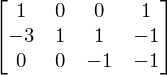

In [7]:
units, dimension_matrix = \
   construct_dimension_matrix( parameters )

dimension_matrix

As you can verify, the columns correspond to the parameters in the order in which they were given. The rows correspond to the fundamental units in alphabetical order, so the first row is kilograms, the second row is meters, and the last row is seconds. So, reading down the third row, we can see that the velocity parameter $u_0$ has units of $\mathrm{m}/\mathrm{s}$.

We learned previously that the nondimensional numbers which you can make out of the parameters provide, in a sense, a fundamental description of the problem. Furthermore, when we cast the problem in terms of the dimension matrix, the nondimensional numbers are precisely the set of vectors which span the nullspace of the matrix.

Thus, since we have the dimension matrix, all we have to do now is find its nullspace. Fortunately, Sympy has a function which does exactly this (sensibly named `nullspace()`), thus saving us a fair amount of effort:

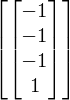

In [8]:
nullspace = dimension_matrix.nullspace()
nullspace

As we can see, the nullspace of this matrix is a single vector. This vector is a recipe for how to combine the parameters in such a way that the result has no dimensions. So the vector tells us that we have one power of $\eta$, and negative one power of each of $\rho$, $u_0$, and $D$, or

\begin{equation}
\frac{\eta}{\rho u_0 D}
\end{equation}

which you may recognize as the inverse of the Reynolds number!
Recall that the Reynolds number characterizes the ratio of inertial effects to viscous effects for a fluid.
Note that it makes no difference that this is the inverse of the traditionally defined Reynolds number: it is still a perfectly valid nondimensional number, and any power of it is also perfectly valid. The Reynolds number itself is just a convention for how to define the relevant nondimensional number.

At this point, we have successfuly written some code that takes some parameters, assembles the dimension matrix and finds the nondimensional numbers associated with that problem. We could be done. It would be nice, however, not to have to read the parameters off of a vector of rational numbers, as we did above. Fortunately, it is not too difficult to write a new class, `NondimensionalNumber`, which takes care of these details. 

The class is initialized with the list of parameters and a particular vector in the dimensional nullspace. It has an internal function `_parse_nondimensional_number()` which takes that vector and parses it into a nice string which can be typeset via $\LaTeX$. If you are not comfortable with $\LaTeX$ typesetting, feel free to skip this block, it is mostly cosmetic:

In [9]:
class NondimensionalNumber(object):
    def __init__(self, parameters, nondimensional_vector):
        self.parameters = parameters
        self.vector = nondimensional_vector
        self.string_representation = self._parse_nondimensional_number()
        
    def _parse_nondimensional_number(self):
        # Initialize two empty strings for the numerator and 
        # denominator of the nondimensional number
        numerator_string = ''
        denominator_string = ''
    
        for p,n in zip(self.parameters, self.vector):
            # No need to typeset the parameters if they do not 
            # appear in the nondimensional number
            if n == 0:
                continue
            # If the exponent on the parameter is one,
            # we do not need to write it.
            if n == 1 or n == -1:
                parsed_parameter = p.symbol
            # If the exponent is a whole number, we do
            # not need to represent it as a fraction.
            elif n.q == 1 or n.q == -1:
                parsed_parameter = p.symbol + \
                        '^{%i}'%(abs(n.p))
            # Otherwise, represent it as a fraction
            else:
                parsed_parameter = p.symbol + \
                        '^{%i/%i}'%(abs(n.p), abs(n.q))
    
            # Depending upon whether the exponent is positive or 
            # negative, put it in the numerator or the denominator
            if n > 0:
                numerator_string = ' '\
                    .join([numerator_string, parsed_parameter])
            elif n < 0:
                denominator_string = ' '\
                    .join([denominator_string, parsed_parameter])
        
        # If the numerator is empty, make it a one
        if numerator_string == '':
            parsed_number = '\\frac{1}{'+denominator_string+'}'
        # If the denominator is empty, there is no need for a fraction
        elif denominator_string == '':
            parsed_number = numerator_string
        # Otherwise make it a fraction
        else:
            parsed_number = '\\frac{'+numerator_string+\
                            '}{'+denominator_string+'}'
                        
        # And we are done! We return a LaTeX string
        return parsed_number
    
    # Let IPython know how this may be typeset with LaTeX
    def _repr_latex_(self):
        return '$$'+self.string_representation+'$$'
    # Return the string form of the nondimensional number
    def __str__(self):
        return self.string_representation

# This is a bit of a hack: Here I am subclassing
# the builtin Python list type and adding a
# function for print_latex(). This allows
# IPython to be able to render a list of 
# nondimensional numbers as well as a single one.
class NondimensionalNumberList(list):
    # Make a comma delimited list of the 
    # nondimensional numbers
    def __str__(self):
        string_representation = ''
        for n in range(len(self)):
            s = str(self.__getitem__(n))
            string_representation += s
            if n != len(self)-1:
                string_representation += ', '
        return string_representation
    
    #Add symbols for typesetting with LaTeX
    def print_latex(self):
        return '$$'+self.__str__()+'$$' 

# Register the print function with IPython
_ = get_ipython().display_formatter.formatters['text/latex'].\
    for_type(NondimensionalNumberList, \
             NondimensionalNumberList.print_latex)


We can now use this function to typeset the Reynolds number:


In [10]:
Re = NondimensionalNumber(parameters, nullspace[0])
Re


To finish this coding exercise, we can tie it all up into a single function that takes a list of parameters and returns a list of nondimensional numbers. Remember, the overall steps to this process were

1. Construct the dimension matrix
2. Find the vectors spanning the nullspace of the dimension matrix
3. Parse those vectors into human-readable nondimensional numbers

We have already done each of these steps individually, we just need to put them in one place, the function `find_nondimensional_numbers()`:

In [11]:
def find_nondimensional_numbers( parameters ):
    # First, create the dimension matrix
    units, dimension_matrix = \
        construct_dimension_matrix(parameters)
    # Second, find the nullspace of the dimension matrix
    nullspace = dimension_matrix.nullspace()
    # Third, convert the vectors in the 
    # nullspace to nondimensional numbers
    nondimensional_numbers = NondimensionalNumberList(\
                [NondimensionalNumber(parameters, v) \
                 for v in nullspace])
    # Finally, return the list of nondimensional numbers
    return nondimensional_numbers

And now we can find the Reynolds number by calling this function:

In [12]:
nondim = find_nondimensional_numbers(parameters)
nondim

That's more like it! We now have the problem of finding the nondimensional numbers associated with a particular problem down to a single function call! 


## More involved examples

The problem we have been working with is a relatively simple problem, with a single nondimensional number. More complicated problems can have many nondimensional numbers, each describing some aspect of the physics of the problem. That is to say, as we add more physics, we expect to have more nondimensional numbers at play. I'd like to close out this article with a coupld of examples of this.

First, we can consider an elaboration on shearing flow: what if the fluid was a river? Like Couette flow, rivers exist in a channel, but they also move under the influence of gravity. The force of gravity determines the dynamics of ripples and waves along its surface and the speed at which the river moves downhill. It also is extremely important for characterizing the rate of [sediment transport](https://en.wikipedia.org/wiki/Saltation_%28geology%29) downstream, which has important geomorphological, agricultural, and environmental consequences.

![oranje](images/oranje.jpg "All right! An excuse for a picture!")

Since gravity is a primary control on the river dynamics, we had better include that in our list of parameters. Regenerating the parameter list, and finding the nondimensional numbers, we get

In [13]:
parameters = [density, length, velocity, viscosity, gravity]
nondim = find_nondimensional_numbers(parameters)
nondim


We see that, as before, we get one over the Reynolds number $1/Re$. However, now there is a second nondimensional number, given by
\begin{equation}
\frac{D g}{u_0^2}
\end{equation}
This number is a direct consequence of our adding the effects of gravity to the problem. We can see this as the ratio of gravitational forces ($\sim \rho g$) to inertial effects ($\sim \rho u_0^2/D$). As with the Reynolds number, this quantity is important enough that it has a name: the [Froude number](https://en.wikipedia.org/wiki/Froude_number).

Actually, the Froude number is usually defined as 
\begin{equation}
\mathrm{Fr} = \frac{u_0^2}{\sqrt{g D} }
\end{equation}
so what we actually found was $1/\mathrm{Fr}^2$. But remember, this is just a convention, and any power of a nondimensional number is just as valid. As you might imagine, the ratio of inertia to gravity is the primary control on the shape of waves in moving water, and as such is extremely important in the hydrodynamic design of ships.

![shipwreck](images/shipwreck.jpg "Too much Froude, too much Reynolds")


We'll consider a final example from geodesy of the solid Earth.
When a magma chamber underneath a volcano gets a fresh infusion of magma, the chamber gets overpressured.
This overpressure deflects the overlying surface upwards, which can be detedcted via satellites using [INSAR](https://en.wikipedia.org/wiki/Interferometric_synthetic_aperture_radar).
The image below depicts the deflection of Earth's surface at a volcano in the Galapagos from a study by [Amelung et. al.(2000)](http://dx.doi.org/10.1038/35039604)

![mogi](images/mogi.jpg "It's gonna blow...")

We would like to understand how the Earth deforms due to the overpressure in the magma chamber.
Using a dollop of intuition, we suppose that the deflection of the surface depends on the radius of the magma chamber $R$, the depth of the magma chamber $D$, and the overpressure $\Delta P$. 
Furthermore, it must depend on the elastic properties of the rock (which control how the rock deforms due to some stress).
We can describe these elastic properties using the shear modulus $\mu$ and the dimensionless Poisson's ratio $\nu$.

Using the package we have developed, we can define these five parameters and find the nondimensional numbers.

In [14]:
overpressure = Parameter('\\Delta P', {'kg' : 1, 'm' : -1, 's' : -2})
shear_modulus = Parameter('\\mu', {'kg' : 1, 'm' : -1, 's' : -2})
poisson_ratio = Parameter('\\nu', {})
depth = Parameter('D' , {'m': 1})
radius = Parameter('R' , {'m': 1})

parameters = [poisson_ratio, overpressure, shear_modulus, depth, radius]
nondim = find_nondimensional_numbers(parameters)
nondim

We find that the relevant nondimensional numbers are Poisson's ratio (already dimensionless), the ratio of the shear modulus to the overpressure, and the ratio of the radius of the magma chamber to its depth.
Comparison with an analytical approximation to this system, the Mogi source, shows that these three nondimensional numbers are the important controls on the system.

##Conclusion

That was a bit of a longer article than I intended, but I hope it provided an interesting perspective on dimensional analysis. 
I welcome comments and improvements to [Buckinghampy](https://github.com/ian-r-rose/buckinghampy), which I intend to be a teaching tool for this topic.
In my next post, I hope to take a dive into the problem which proved to be the beginning of the end for classical physics: the [ultraviolet catastrophe](https://en.wikipedia.org/wiki/Ultraviolet_catastrophe).
As is my wont, I will be doing so from the perspective of dimensional analysis.
How far can you get with this perspective? It turns out, surprisingly far!